In [5]:
#import of libraries
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve, precision_score, recall_score

from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore') 

---
# Supervised Machine Learning (Classification) on Heart Attack Data

The follow assignment will explore Heart Attack Data and explore 3 separate models to assess the accuracy of predicting heart attack. The dataset used in this task can be found at; https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

Features:

*   Age : Age of the patient
*   Sex : Sex of the patient
*   exang: exercise induced angina (1 = yes; 0 = no)
*   ca: number of major vessels (0-3)


*   cp : Chest Pain type chest pain type :
*   cp Value 1: typical angina
*   cp Value 2: atypical angina
*   cp Value 3: non-anginal pain
*   cp Value 4: asymptomatic


*   trtbps : resting blood pressure (in mm Hg)
*   chol : cholesterol in mg/dl fetched via BMI sensor
*   fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)


*   rest_ecg : resting electrocardiographic results :
*   Value 0: normal
*   Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
*   Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria


*   thalach : maximum heart rate achieved
*   target : 0= less chance of heart attack 1= more chance of heart attack

Let's begin by importing our data into pandas.

In [6]:
#path must point to the heart.csv file.
data = pd.read_csv('/content/heart.csv', index_col=None, header=0)
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
data.shape

(303, 14)

---
# Data Cleaning

Before we start exploring our dataset, lets first do some simple checks to see if we need to do anything. Below, we shall check our datatypes, see if there are any missing values in each row, and check for any duplicate values.


In [8]:
#Count missing values in each column.
data.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [10]:
#duplicate values check
data.duplicated().sum()
data.loc[data.duplicated(keep=False),:]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


As we can see, we are primarily working with "Int"-type values. This means we do not require any more work to change the features of the data. We also have no absent attributes in each row, but we have discovered duplicate values. All we need to do is just drop this value and continue forward.

In [11]:
#drop duplicates
data.drop_duplicates(keep='first', inplace=True)

---
# Data Exploration
Let’s look at our data and see any noticeable correlations. The below table describes how our data is distributes per each column. Though, this doesnt represent much use since some of the attributes are numerical encodings and aren’t represented well like this.

In order to see correlations, lets visually interpret this data through a heatmap of correlated values, and a pair plot to draw visual inferences between columns.


In [9]:
#Description of out dataset, rounded to two decimal places
data.describe().round(2)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.68,0.97,131.62,246.26,0.15,0.53,149.65,0.33,1.04,1.40,0.73,2.31,0.54
std,9.08,0.47,1.03,17.54,51.83,0.36,0.53,22.91,0.47,1.16,0.62,1.02,0.61,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.50,0.00,0.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,2.00,0.00
50%,55.00,1.00,1.00,130.00,240.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,2.00,1.00
75%,61.00,1.00,2.00,140.00,274.50,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00,1.00


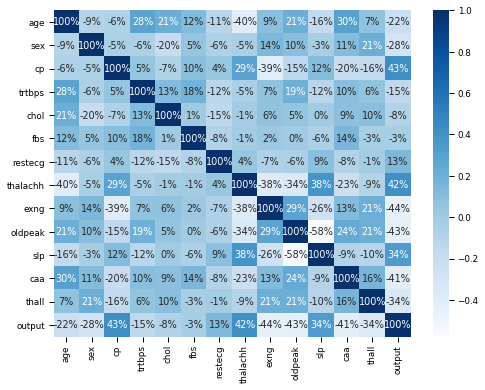

In [12]:
data_corr = data.corr()
data_corr
plt.figure(figsize=(8,6))
sns.set_context('paper')

sns.heatmap(data_corr, annot=True, cmap='Blues', fmt='.0%')

From the above correlation plot we can see correlations between "output" and the following:
*   cp (43%)
*   thalachh (42%)
*   slp (34%)

The above attributes represent the highest correlated attributes, thought there are some notable correlations listed below:
*   age and caa, trtbps
*   cp and thalachh
*   chol and age
*   thalachh and slp, cp
*   exng and oldpeak
*   oldpeak and caa
*   thall and exnp, oldpeak, age


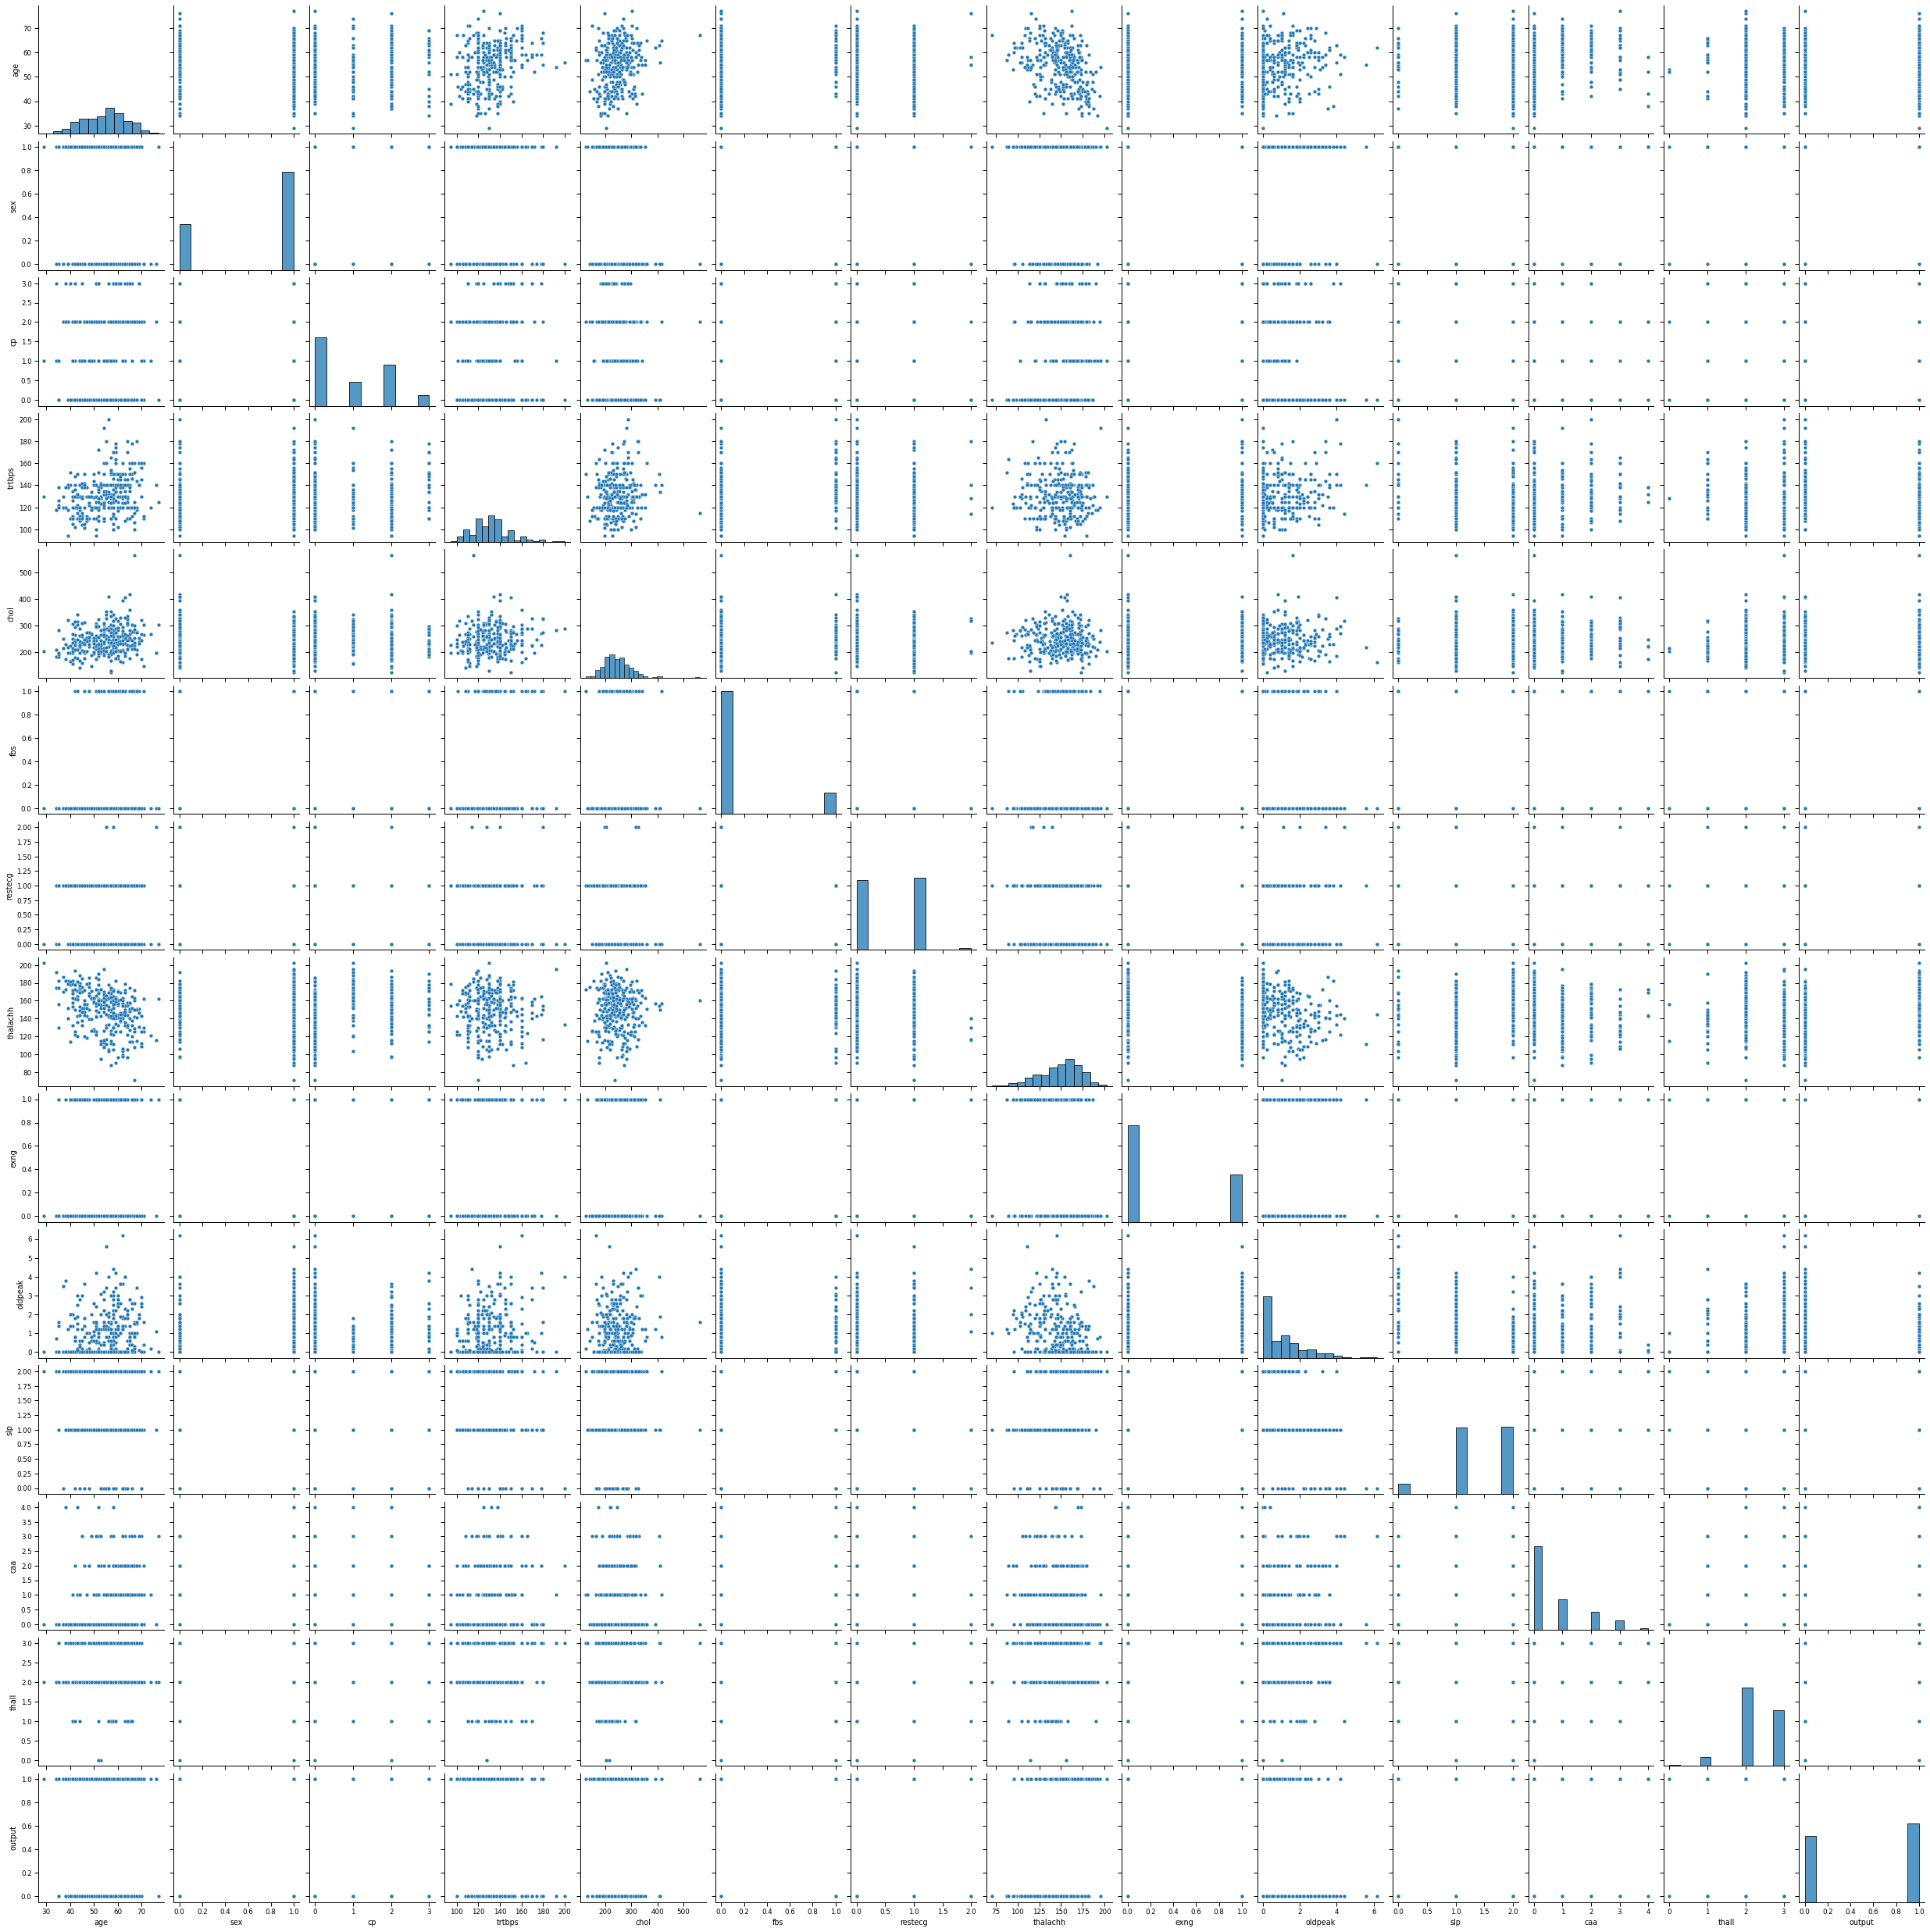

In [13]:
#broad look at data distribution
sns.pairplot(data)

The below plots depict the density of data in accordance with what would be a high likely hood and a low likelihood of heart attack risk. This gives insight to the shape of the data given the output of events.

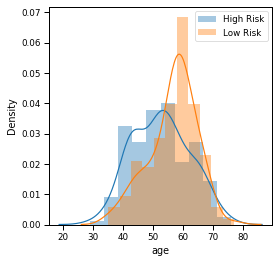

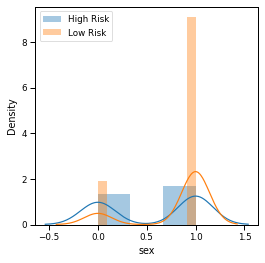

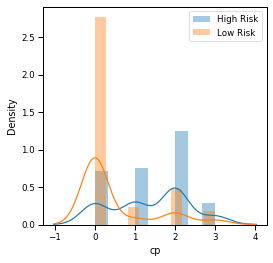

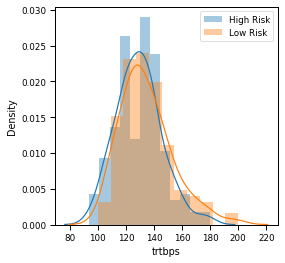

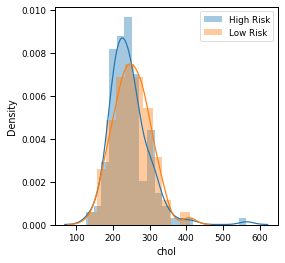

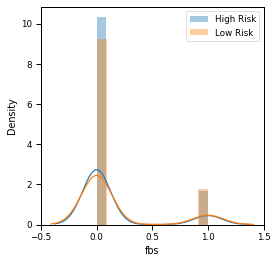

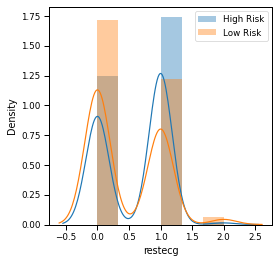

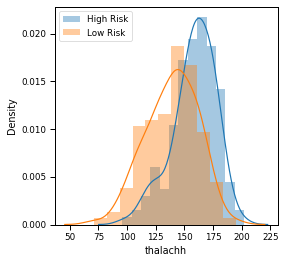

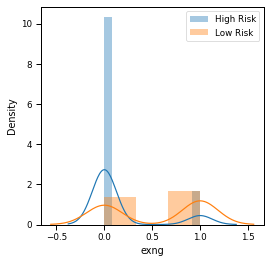

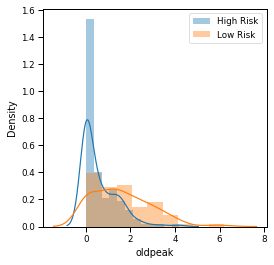

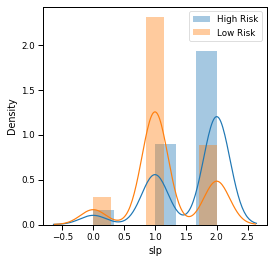

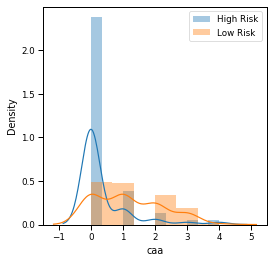

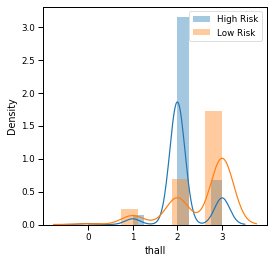

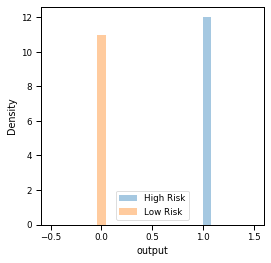

In [14]:
X = data.drop('output',axis=1)
y = data['output']

riskyDF = data[y == 1]
safeDF = data[y == 0]

for col in data.select_dtypes(include=['float64','int64']):
    plt.figure(figsize=(4,4))
    sns.distplot(riskyDF[col],label='High Risk')
    sns.distplot(safeDF[col],label='Low Risk')
    plt.legend()
    plt.show()

---
# Data Engineering/Modelling

Because the data is already in a numerical form (int-type), it will not be required to engineer the data or reencode values. Though, given the tasks ahead, we may require data scaling for input into specific classifier models.

We shall address this problem as we arrive to it. But for now, we can get to creating our train-test split.


In [16]:
#train test splitting
y = data['output']
x = data.drop('output', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

---
# Classifier Model 1: KNN

First let’s explore using K-Nearest Neighbour (KNN) algorithm. The KNN algorithm assumes that similar things exist in proximity. In other words, similar things are near to each other. KNN algorithm assumes the similarity between the new case/data and available cases and put the new case into the category that is most like the available categories.

For this algorithm to work we need to scale the test/train data. To do this, I shall generate a pipeline. This will allow scaling the train/test data without taking up additional resources or modifying the original test/train split, as well as keep the use of our train/test split uniform across the other two classification models.


In [17]:
KNN_pipeline = Pipeline([('ss', StandardScaler()), ('knn', KNeighborsClassifier())])

KNN_pipeline.fit(x_train, y_train)
KNN_pipeline.score(x_test, y_test)

y_proba = KNN_pipeline.predict_proba(x_test)
y_pred = np.argmax(y_proba,axis=1)
print("KNN : ", accuracy_score(y_test, y_pred))

KNN :  0.8571428571428571


Can we increase our accuracy of our KNN Classifier?! Let's find out below by running the pipeline through a for-loop, increasing the number of neighbours for selection, and plotting the accuracy out to see the change in value.

Text(0, 0.5, 'Mean Err')

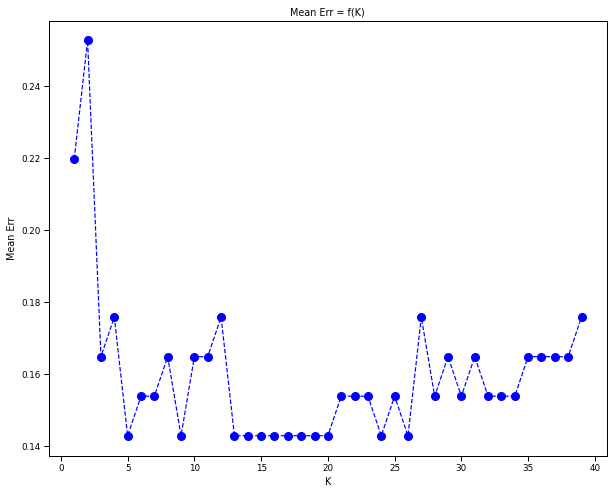

In [18]:
err = []
  
for i in range(1, 40):
    
    model = Pipeline([('ss', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = i))])
    model.fit(x_train, y_train)
    pred_i = model.predict(x_test)
    err.append(np.mean(pred_i != y_test))
  
plt.figure(figsize =(10, 8))
plt.plot(range(1, 40), err, color ='blue',
                linestyle ='dashed', marker ='o',
         markerfacecolor ='blue', markersize = 8)
  
plt.title('Mean Err = f(K)')
plt.xlabel('K')
plt.ylabel('Mean Err')

The above output suggests that a value of "5" should be the most optimized value.

In [19]:
KNN_pipeline_Opt = Pipeline([('ss', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 5))])
KNN_pipeline_Opt.fit(x_train, y_train)
y_proba = KNN_pipeline_Opt.predict_proba(x_test)
y_pred = np.argmax(y_proba,axis=1)

print("KNN : ", accuracy_score(y_test, y_pred))

KNN :  0.8571428571428571


However, this seems to be negligible since the resultant accuracy has no increased any more than the first model.

---
# Classifier Model 2: Decision Tree Classification

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

However for this use case, we are going to use it to classify attributes to create a process of decision to predict a patients possibility of a heart attack.


In [20]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(x_train, y_train)

dt.tree_.node_count, dt.tree_.max_depth

(79, 8)

In [29]:
# The error on the training and test data sets (Taken from workbook)
y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,1.0,0.824176
precision,1.0,0.883721
recall,1.0,0.775510
f1,1.0,0.826087


The above output shows out accuracy prediction. This is quite low, could it be improved with Grid Search Cross Validation (GSCV)?! Let's find out below:

In [30]:
# Grid Search optimization
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2), 'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid, scoring='accuracy', n_jobs=-1)

GR = GR.fit(x_train, y_train)
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(15, 3)

In [31]:
y_train_pred_gr = GR.predict(x_train)
y_test_pred_gr = GR.predict(x_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error

,train,test
accuracy,0.862559,0.835165
precision,0.841270,0.854167
recall,0.921739,0.836735
f1,0.879668,0.845361


We have increased the accuracy by 0.01 but at the cost of our precision. Also, our recall has increased significantly. Let’s look at the two different trees:

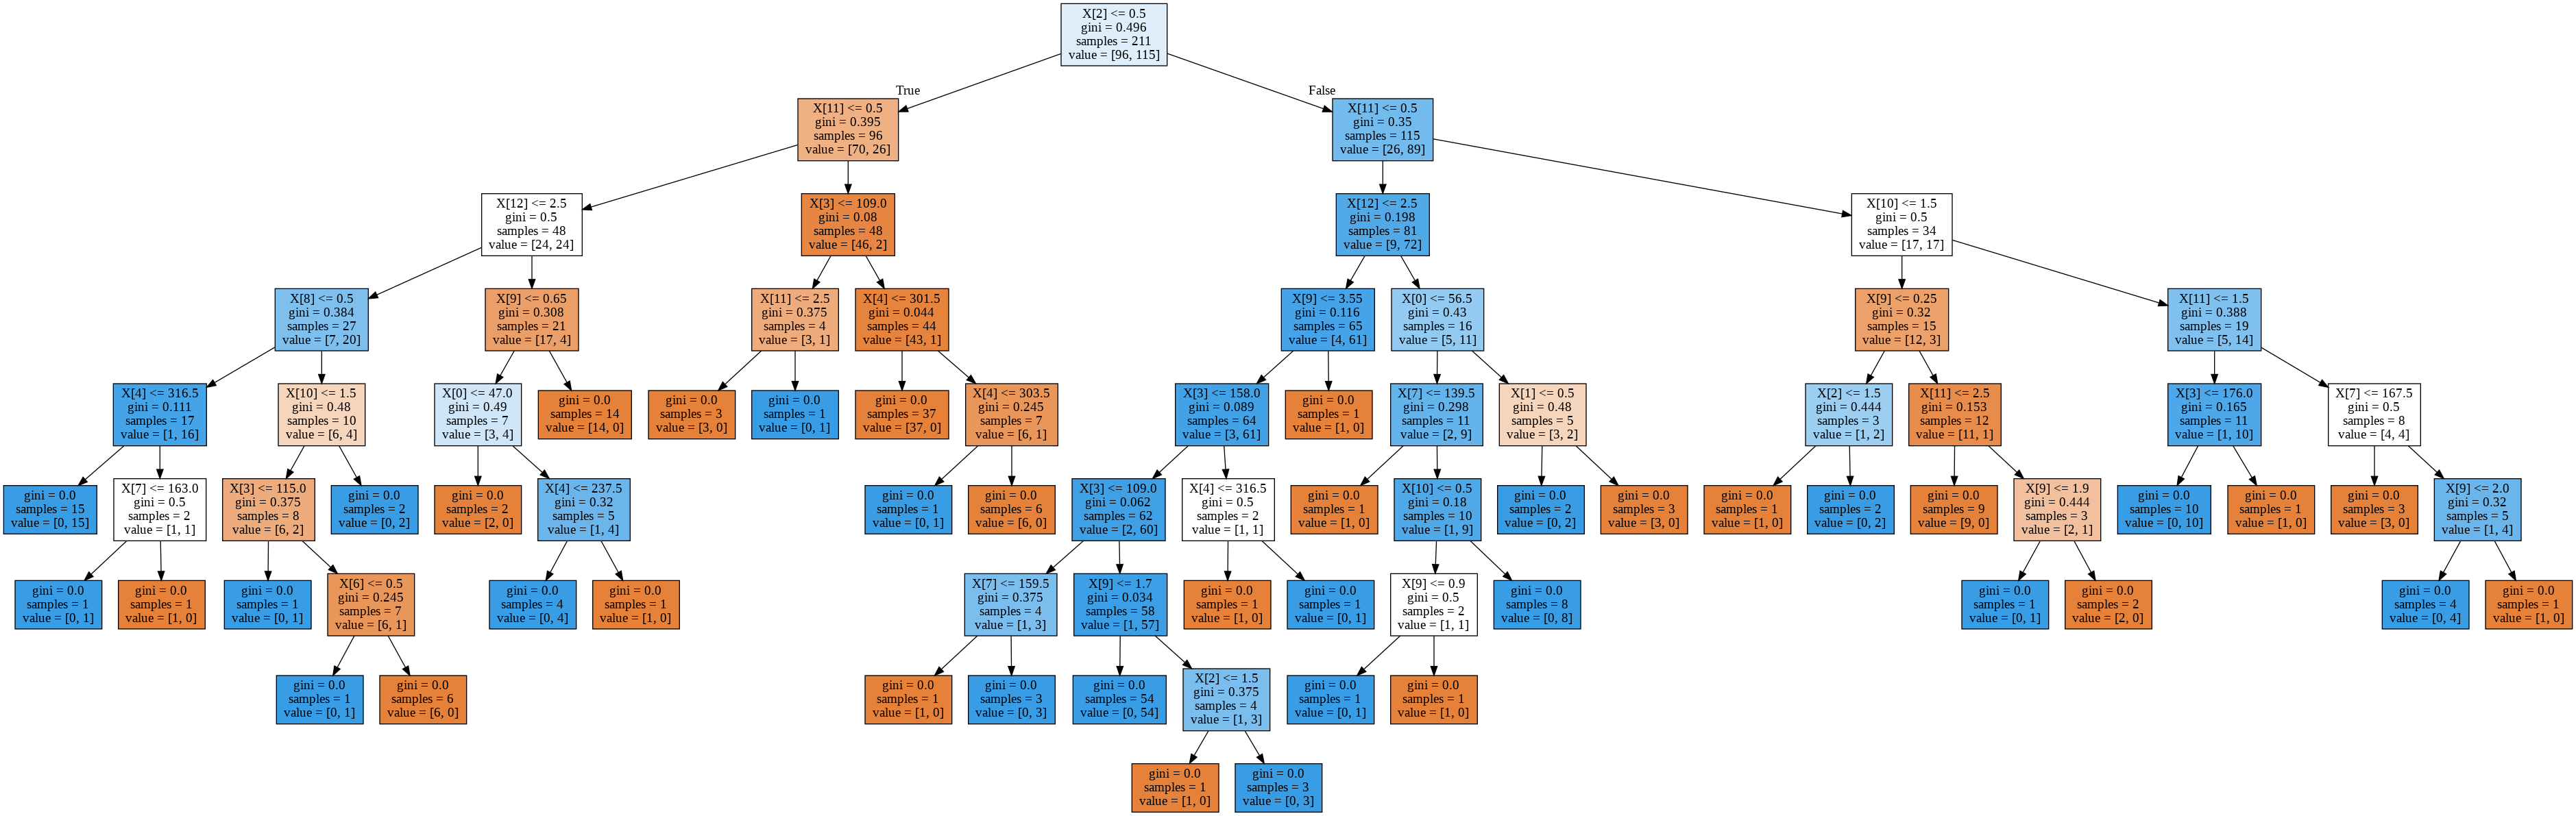

In [27]:
# Create an output destination for the file
dot_data = StringIO()

export_graphviz(dt, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = 'tree_1.png'
graph.write_png(filename)
Image(filename=filename) 

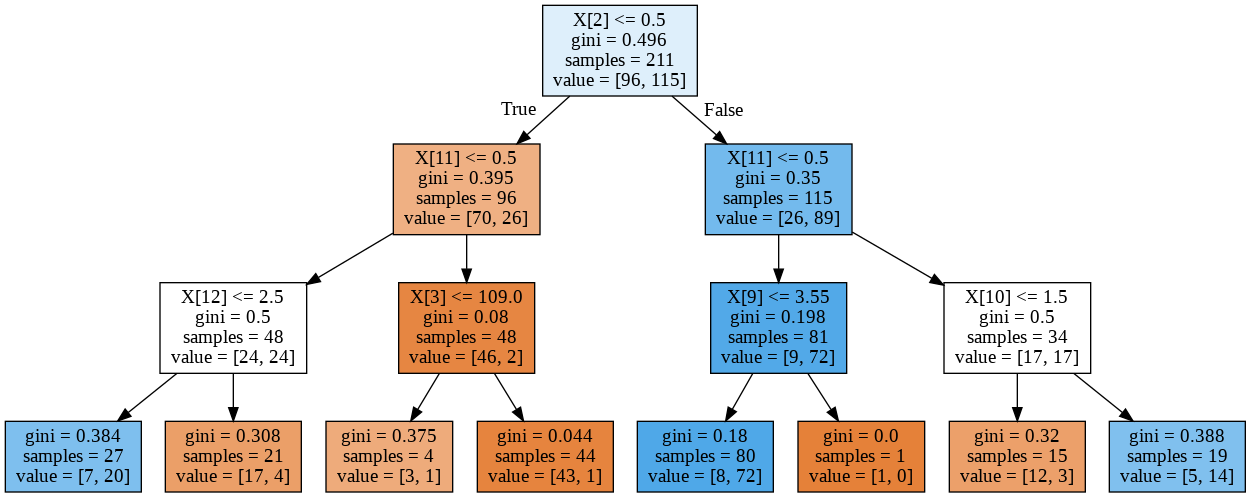

In [28]:
# Create an output destination for the file
dot_data = StringIO()

export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# View the tree image
filename = 'tree_2.png'
graph.write_png(filename)
Image(filename=filename) 
### END SOLUTION

---
# Classifier Model 3: Random Forest Classification

Random forest is an ensemble machine learning algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests create decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance. Let’s see how well our heart attack data is classified by Random Forest.


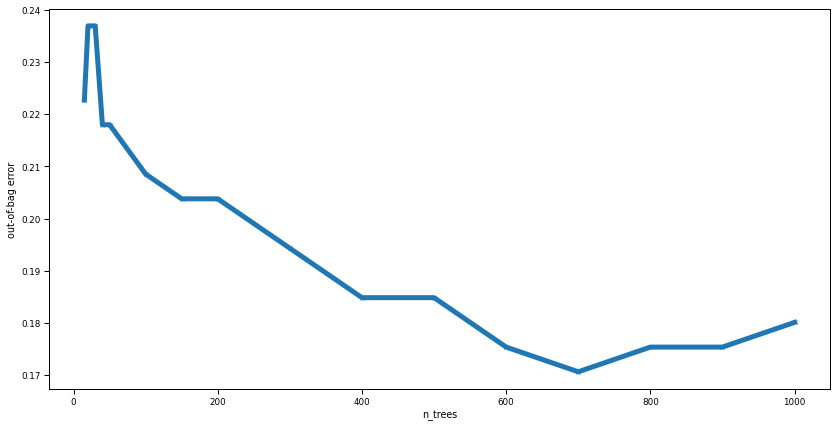

In [32]:
# Initialize the random forest estimator
# Note that the number of trees is not setup here
RF = RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)
    # Fit the model
    RF.fit(x_train, y_train)
    # Get the oob error
    oob_error = 1 - RF.oob_score_
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

ax = rf_oob_df.plot(legend=False, marker='x', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

The key is to reduce our out-of-bag (OOB) error. We do this by increasing the number of possibilities and finding the possibility which produced the lowest OOB score. In this case, the lowest score is "700"

In [36]:
from sklearn.metrics import f1_score, roc_auc_score

# Random forest with 700 estimators
model = RF.set_params(n_estimators=700)
y_pred = model.predict(x_test)

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        42
           1       0.84      0.88      0.86        49

    accuracy                           0.85        91
   macro avg       0.85      0.84      0.84        91
weighted avg       0.85      0.85      0.85        91

   accuracy  precision    recall    f1       auc
0  0.846154   0.843137  0.877551  0.86  0.843537


Picking our most optimised number (700), we achieve an accuracy of 0.85 (rounded up). Let’s visually see how this is reflected in the ROC curve and precision/recall curve.

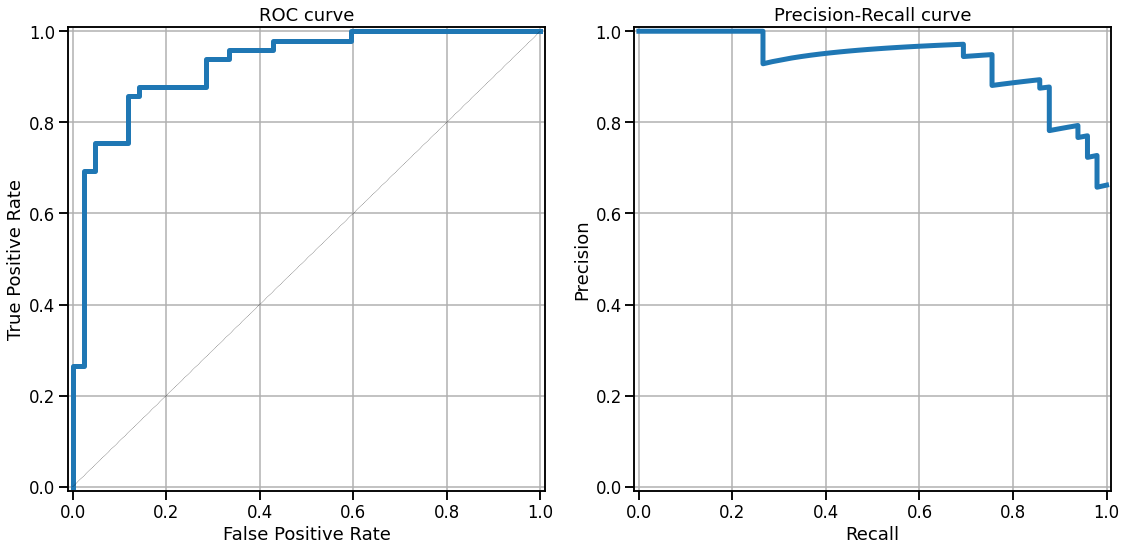

In [38]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(x_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=[-.01, 1.01], ylim=[-.01, 1.01], title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision', xlim=[-.01, 1.01], ylim=[-.01, 1.01], title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

Looking at the ROC curve, the true positive rate begins to severely fall off as the precision exceeds 8.0 resulting in a 60% hance if the true positive rate is 100% of a false positive rate.

Similarly, to the precision/recall curve. Anything above a 0.7 in the recall leads to a sharp drop off in the precision rate.

---
# Summary/Key Findings/Next Steps

To summarize, this task has explored Heart Attack data and the accuracy of three different classification models to measure predictability of a heart attack. We have explored:

*   KNN (accuracy: 0.8571428571428571)
*   Decision Tree's (accuracy: 0.835165 given the test data and after GSCV)
*   Random Forests (accuracy: 0.846154)

Given the scores of accuracies, I beleive a KNN model is of best fit for the data. However, to accommodate for whats easier to demonstrate explainability of the model, I do feel that decision tree's best fit this case as there is an easy visual representation to the structure of the decision-making process.

Precision was a mixed batch, given if recall was a factor, Decision tree's with GSCV optimisation provided the highest Recall but compromises with precision. Ultimately you want a system with high precision and high recall which return many results, with all results labelled correctly.
